# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2024

Barri, Alfa Umar, 1952357

Thiboutot, Thomas, 2143877

Note finale :

 <u>**Date limite de remise :**</u>  27 mars 23h59 (Groupe B1), 19 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition (en gris).

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time

In [2]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.
    """
    # Create a figure and axis
    _, ax = plt.subplots()

    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')

    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)

    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)

    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [3]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

# partition = readFile('Chansons/twinkle_twinkle.txt')
partition = readFile('Chansons/fur_elise.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 2022


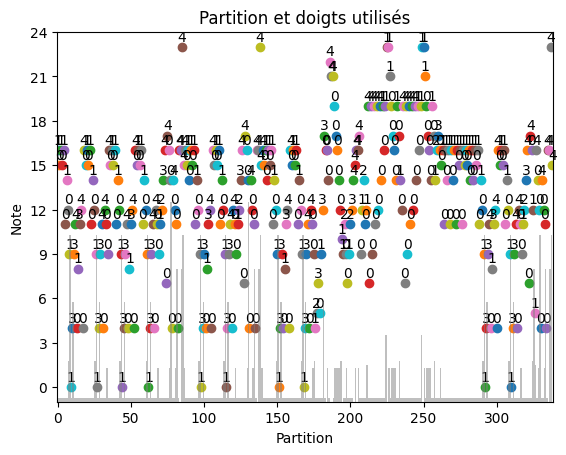

In [52]:
def glouton(partition):
    solution = [0 for i in range(len(partition))]

    # first 2 notes
    init_costs = costs[partition[0],:,partition[1],:]
    solution[0], solution[1] = np.unravel_index(np.argmin(init_costs), init_costs.shape)
    # remaining notes
    for i in range(2, len(partition)):
      temp = [costs[partition[i-1]][solution[i-1]][partition[i]][x] for x in range(D)]
      solution[i] = np.argmin(temp)

    return solution


solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

On commence par initialiser la solution en ordre O(n) ou n est la longueur de la partition.
Nous avons également numpy.argmin qui s'exécute en O(D^2) puisque qu'elle itère sur tout les éléments de la matrice de coût initiale de taille DxD. 
On itère dans une boucle n-2 fois dans laquelle on opère une boucle D fois de recherche pour le coût minimal du doigt suivant. L'ordre de complexité temporelle de cette boucle est donc O(n*D)
L'ordre de complexité temporelle de notre algorithme glouton est donc max(O(n*D), O(D^2), O(n)) où n est toujours plus petit que n*D ou D^2 puisque D est entier donc -> max(O(n*D), O(D^2))

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [6]:
dataset = {}

for i in range(5, len(partition), 5):
  dataset[i] = [partition[:i] for _ in range(100)]

measures_glouton = measure_procedure(glouton, dataset)
display_measures_table(measures_glouton)

Taille       Temps moyen (s)100 of size 335...          
5            3.832578659057617e-05
10           6.797552108764649e-05
15           9.40561294555664e-05
20           8.082151412963867e-05
25           8.996248245239257e-05
30           0.00019205331802368163
35           0.00016080379486083985
40           0.00018521785736083985
45           0.0002093362808227539
50           0.00023287773132324219
55           0.00026329994201660154
60           0.0002644491195678711
65           0.0004399991035461426
70           0.0004042363166809082
75           0.0003786206245422363
80           0.0003943037986755371
85           0.00042321443557739256
90           0.0004624581336975098
95           0.0006742668151855469
100          0.0005377364158630371
105          0.0005390477180480957
110          0.0005409741401672364
115          0.0005613851547241211
120          0.0005796337127685547
125          0.0005755853652954101
130          0.0007336163520812989
135          0.0008460450172

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

#### Test de puissance pour l'algorithme glouton

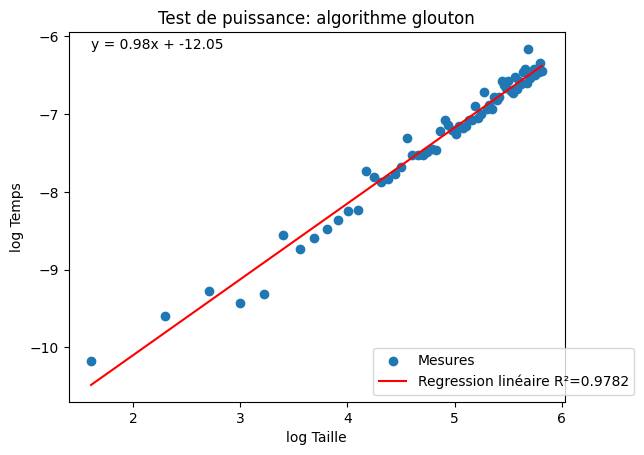

In [7]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_glouton), "Test de puissance: algorithme glouton")

On observe que le graphique en échelle log-log du temps en fonction de la taille donne une droite, ce qui nous indique que l'algorithme suit un temps d'ordre polynomial.
La pente de la droite est de 0.98 et l'ordonnée à l'origine est -12.05. Nous faisons donc une hypothèse sur la fonction sous-jacente h(x) qui donne l'ordre de la complexité asymptotique temporelle de notre algorithme.
Hypothèse : m = 1 => h(x) = x
Cette hypothèse concorde avec notre calcul de la complexité asymptotique puisque D est constant.
L'ordre de complexité avec un nombre de doigt constant devient D*O(n) quand n > D et O(1) quand D > n.

#### Test du rapport pour l'algorithme glouton

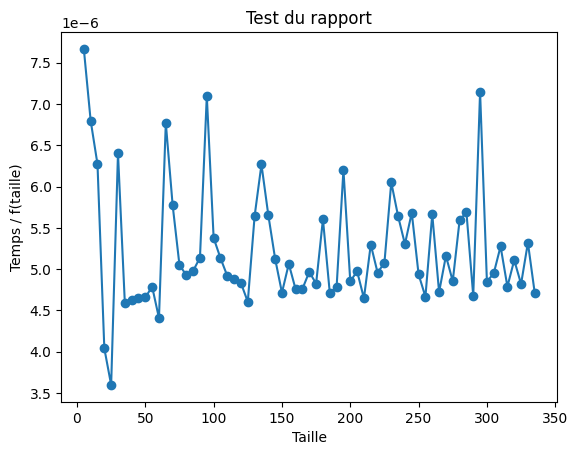

In [18]:
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : measure/f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_glouton, f))

#### Analyse du test du rapport
Le graphique qui représente le temps divisé par l'ordre de complexité en fonction de la taille de l'exemplaire semble donner un ensemble de points qui converge vers 5.0e-6 (5 étant le nombre de doigts). Puisque le test converge, on peut établir que notre hypothèse de temps linéaire de la complexité est valide.
On peut poser une hypothèse sur la constante multiplicative de l'algorithme glouton.

Hypothèse : a = 5.0e-6

Cette valeur est comparable à l'ordonnée à l'origine du test de puissance dont la courbe est donné par: y = log(a) + m*log(x) => a = e^-12.05 = 5.85e-6

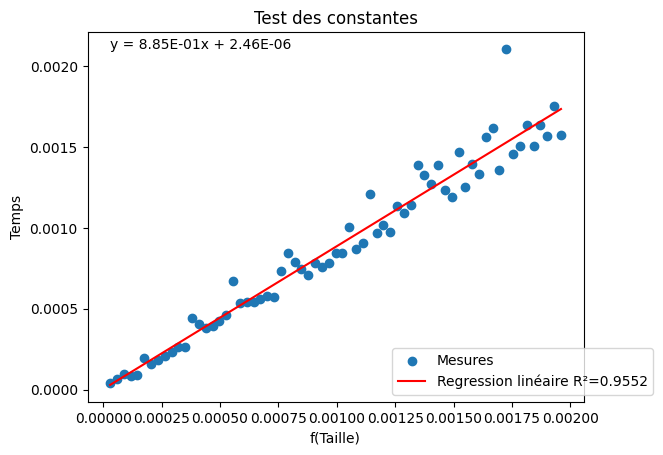

In [21]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return 5.85e-6*x

display_test_constantes(values_test_constantes(measures_glouton, f))

#### Analyse test de constantes de l'algorithme glouton

L'équation de la droite du test des constantes et donnée par : y = a*h(x) + b. En utilisant les valeurs trouvées précédemment, nous obtenons une ordonnée à l'origine positive proche de 0.
La constante b semble être 2.46e-02.

On observe que le temps d'exécution suit belle et bien un ordre linéaire en fonction de la taille de la partition lorsque le nombre de doigt est constant ->  y = 5.85e-6 *x + 2.46e-6

## Partie 2 : Algorithme de programmation dynamique

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

Coût Programmation Dynamique : 1091


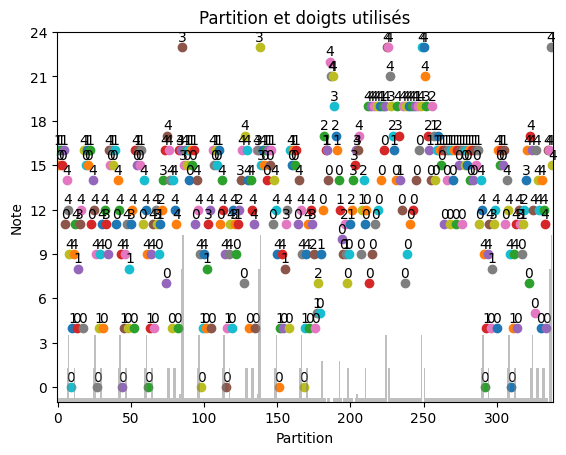

In [23]:
def progDyn(partition):
    solution = [0 for i in range(len(partition))]
    dyn = np.zeros((len(partition), D), dtype=int)
    finger_history = np.zeros((len(partition), D), dtype=int)

    for i in range(len(partition) - 2, -1, -1):
      for j in range(D):
        temp_costs = costs[partition[i], j, partition[i + 1], :]
        prev_finger = np.argmin(dyn[i+1,:] + temp_costs)
        dyn[i][j] = (dyn[i+1,:] + temp_costs)[prev_finger]

        finger_history[i][j] = prev_finger

    solution[0] = np.argmin(dyn[0])
    for i in range(1, len(partition)):
      solution[i] = finger_history[i-1, solution[i-1]]

    return solution

solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

On initialise la solution à la première ligne en O(n) où n est la longueur de la partition. On initialise ensuite les tableaux pour la mémoire en O(n*D) puisque qu'on crée une matrice de taille nxD pour chacun d'eux. On crée une boucle qui itère n fois et une boucle imbriquée qui itère D fois. On assigne les coûts en temps constant et on itère ensuite D fois avec la fonction argmin pour trouver l'index de l'élément minimum. On fait deux assignations puis on quitte la double boucle. L'ordre de complexité de cette boucle est O(n * D * D) mais puisque dans notre cas D est constant -> O(n).
On itère D fois pour assigner la solution au premier indice avec argmin. On itère ensuite n fois pour assigner le reste des solutions. L'ordre de complexité totale de l'algorithme de programmation dynamique est O(n*D^2) puisque n*D^2 > n*D et n*D^2 > n pour un nombre de doigt entiers. 


### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [24]:
dataset = {}

for i in range(5, len(partition), 5):
  dataset[i] = [partition[:i] for _ in range(100)]

measures_dyn = measure_procedure(progDyn, dataset)
display_measures_table(measures_dyn)

Taille       Temps moyen (s)100 of size 335...          
5            6.00433349609375e-05
10           0.00015000581741333007
15           0.00019999265670776368
20           0.00028998851776123046
25           0.00036000967025756836
30           0.0004473066329956055
35           0.0004999971389770508
40           0.0006498432159423828
45           0.0006954693794250489
50           0.0007500195503234863
55           0.0007999873161315918
60           0.0008642959594726562
65           0.0009699869155883789
70           0.0010099411010742188
75           0.001100001335144043
80           0.001150052547454834
85           0.0012599515914916992
90           0.0013399934768676758
95           0.0013800787925720215
100          0.0015026426315307617
105          0.0015532016754150391
110          0.001630685329437256
115          0.001680154800415039
120          0.0018047475814819336
125          0.0018305754661560058
130          0.0018999981880187988
135          0.0019700098037719726

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

#### Test de puissance pour l'algorithme de programmation dynamique

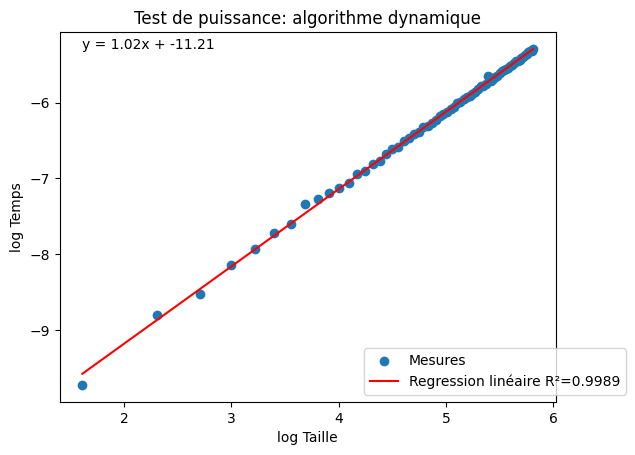

In [25]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_dyn), "Test de puissance: algorithme dynamique")

On observe que le graphique en échelle log-log du temps en fonction de la taille donne une droite, ce qui nous indique que l'algorithme suit un temps d'ordre polynomial.
La pente de la droite est de 1.02 et l'ordonnée à l'origine est -11.21. Nous faisons donc une hypothèse sur la fonction sous-jacente h(x) qui donne l'ordre de la complexité asymptotique temporelle de notre algorithme.
Hypothèse : m = 1 => h(x) = x
Cette hypothèse concorde avec notre calcul de la complexité asymptotique puisque D est constant.
L'ordre de complexité avec un nombre de doigt constant devient D^2*O(n).

#### Test du rapport pour l'algorithme dynamique

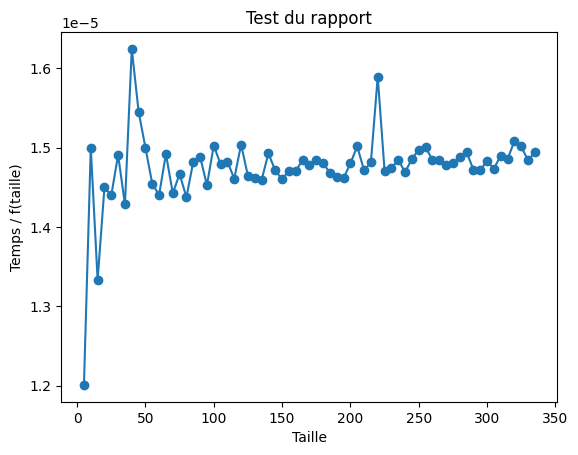

In [33]:
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : measure/f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_dyn, f))

#### Analyse du test du rapport
Le graphique qui représente le temps divisé par l'ordre de complexité en fonction de la taille de l'exemplaire semble donner un ensemble de points qui converge vers 1.5e-5 (5 étant le nombre de doigts). Puisque le test converge, on peut établir que notre hypothèse de temps linéaire de la complexité est valide. On constate également que la valeur de convergence est plus élevé que pour l'algorithme glouton ce qui concorde avec notre hypothèse de complexité : D^2 * O(n) > D * O(n)
On peut poser une hypothèse sur la constante multiplicative de l'algorithme dynamique.

Hypothèse : a = 1.5e-5

#### Test des constantes


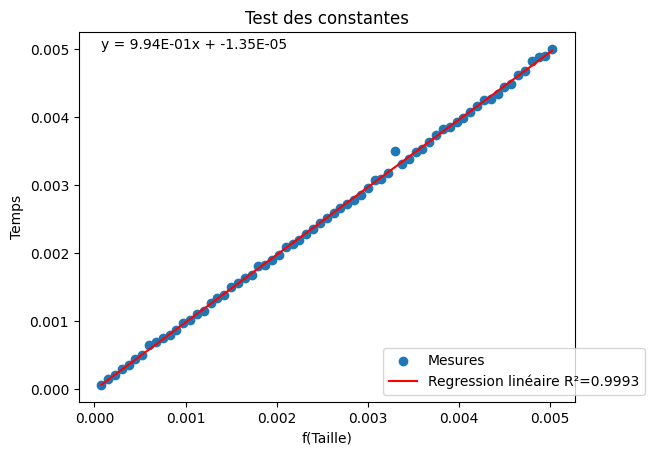

In [34]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return 1.5e-5*x

display_test_constantes(values_test_constantes(measures_dyn, f))

#### Analyse du test des constantes
On observe que le temps d'exécution a une pente de croissance d'environ 1 et une ordonnée à l'origine très proche de 0. 
On peut affirmer que notre hypothèse sur l'ordre de complexité de l'algorithme dynamique est valide.

## Partie 3 : Algorithme de recherche locale

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

Coût Recherche Locale : 1476


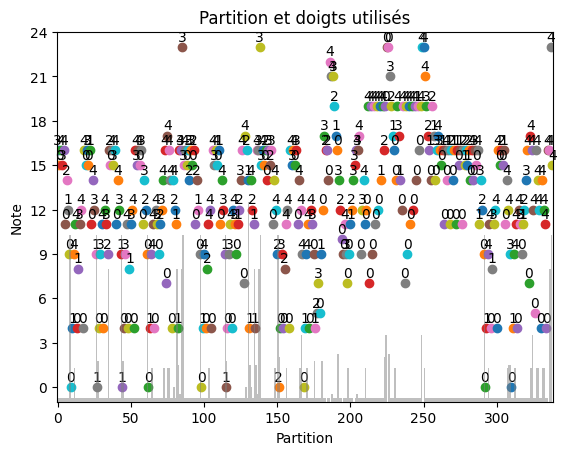

In [99]:
def localSearch(partition):
  
    
    ## Initialisation random 
    solution = [np.random.randint(D) for _ in range(len(partition))]
    #    
    #solution = glouton(partition)  
    niter = 10000
    iter = 0
    
    while iter < niter:
      i = np.random.randint(len(partition))
      old_solution = solution[i]
      old_cost = getTotalCost(costs, partition, solution)
      # amélioration random
      solution[i] = np.random.randint(D)
      new_cost = getTotalCost(costs, partition, solution)
      
      if old_cost < new_cost:
        solution[i] = old_solution
      iter += 1 
    
    return solution

    
solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

On commence par initialiser la solution avec l'algorithme glouton ou aléatoirement. Nous avons analysé l'algorithme glouton comme étant d'ordre max(O(n*D), O(D^2)). Si on initialise aléatoirement la complexité d'initialisation est de O(n) puisque qu'on génère un doigt aléatoire pour chaque indice de la partition de longueur n. On itère ensuite un nombre constant de fois(10000). Dans cette boucle on fait plusieurs assignation en temps constant. L'élément important est l'appel qu'on fait pour trouver le coût total de la solution précédente et suivante. La fonction getTotalCost est d'ordre O(n) puisque qu'elle fait une somme sur tout les éléments de la solution. L'ordre de complexité temporelle de notre algorithme de recherche local est le même que celui de l'algorithme glouton car le reste de l'algorithme se fait en O(10000 * 2n) -> O(n) ce qui est borné supérieurement par l'ordre de l'algorithme glouton. Par contre, avec une initialisation aléatoire la complexité devient O(n) puisque l'initialisation se fait en O(n), car on génère n nombre aléatoire. Le nombre de doigts n'est pas pris en compte dans cet algorithme.


### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [100]:
dataset = {}

for i in range(10, len(partition), 10):
  dataset[i] = [partition[:i] for _ in range(10)]

measures_local = measure_procedure(localSearch, dataset)
display_measures_table(measures_local)

Taille       Temps moyen (s)ple 10 of size 330...          
10           0.3675182104110718
20           0.48171048164367675
30           0.5402146339416504
40           0.6751331567764283
50           0.7630995988845826
60           0.7337132215499877
70           0.8067227602005005
80           0.8054309129714966
90           0.9901083946228028
100          0.9567159652709961
110          1.0779232263565064
120          1.1750798225402832
130          1.2941887378692627
140          1.2361111402511598
150          1.3335580110549927
160          1.439693236351013
170          1.358553671836853
180          1.4990751981735229
190          1.5928371906280518
200          1.5817683219909668
210          1.6880774021148681
220          1.6410056829452515
230          1.7727596759796143
240          1.8884305000305175
250          1.7803406715393066
260          1.9617533922195434
270          2.0005356073379517
280          2.200701880455017
290          2.2412572622299196
300          2

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

#### Test de puissance


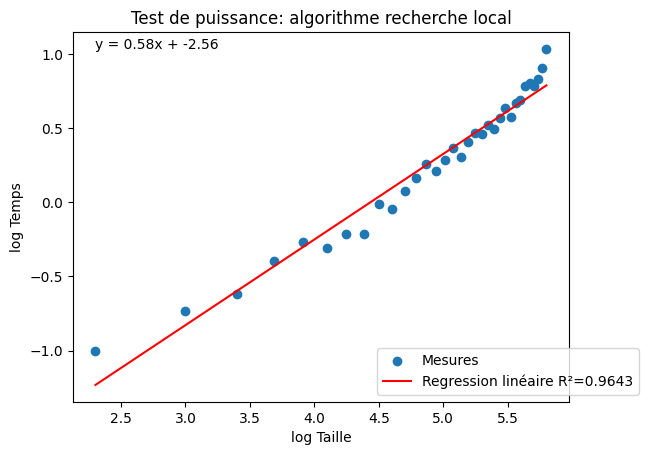

In [103]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_local), "Test de puissance: algorithme recherche local")

#### Analyse test de puissance
On observe que le graphique en échelle log-log du temps en fonction de la taille donne une droite, ce qui nous indique que l'algorithme suit un temps d'ordre polynomial.
La pente de la droite est de 0.58 et l'ordonnée à l'origine est -2.56. Nous faisons donc une hypothèse sur la fonction sous-jacente h(x) qui donne l'ordre de la complexité asymptotique temporelle de notre algorithme.
Hypothèse : m = 0.58 => h(x) = sqrt(x)
Cette hypothèse ne concorde pas avec notre calcul de la complexité asymptotique.



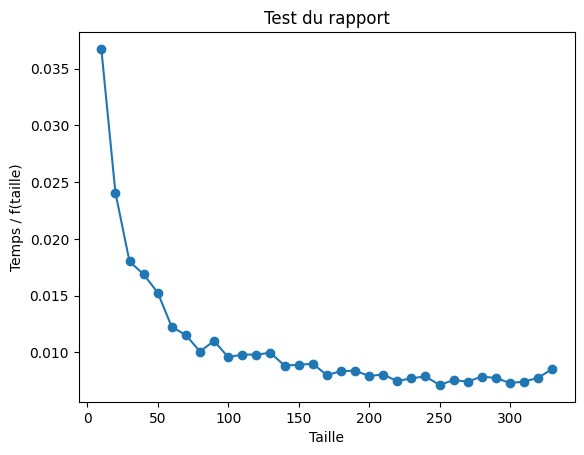

In [108]:
import math
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : measure/f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_local, f))

#### Analyse du test du rapport
Le test du rapport semble converger pour le test du rapport basé sur notre hypothèse d'ordre de complexité linéaire. On peut estimer la valeur de la constante multiplicative «a» à 0.005
ce qui est cohérent avec la boucle de 10000 itérations si on compare avec l'ordre de grandeur des constantes multiplicatives des autres algorithmes

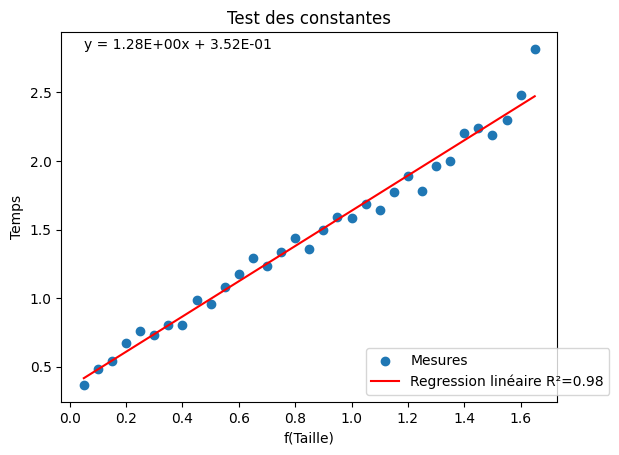

In [115]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return 0.005*x

display_test_constantes(values_test_constantes(measures_local, f))

####  Analyse du test des constantes

On voit que la pente qui devrait être de 1 est de 1.28 ce qui veut dire que nous avons légèrement sous-estimé la constante multiplicative. On voit également que nos mesures suivent une droite avec une ordonnée à l'origine de 3.52e-1. On peut donc conclure que notre algorithme suit un ordre de complexité linéaire -> y = 0.005*x + 0.352

# Conclusion et synthèse

Résumez succintement vos résultats et indiquez sous quelles conditions vous utiliseriez chacun des algorithmes.

Nos résultats nous indiquent que les trois algorithmes suivent des ordres de complexité polynomial linéaire. L'algorithme glouton est plutôt rapide et nous donne un résultat correct. L'algorithme de programmation dynamique nous donne un résultat optimal et prend à peine plus de temps d'exécution que l'algorithme glouton. Il est parcontre plutôt gourmand en ressources mémoire. L'algorithme de recherche est le plus lent de tous dû à sa constante multiplicative élevé. Celle-ci est nécéssaire afin d'obtenir de bons résultats mais il est toutefois possible de diminuer cet constante pour accélérer les calculs en compromettant les résultats. Cette analyse est faite sous la contrainte du nombre de doigt constant. Si le nombre de doigts était variable, il serait intéressant de recomparer nos résultats. L'algorithme glouton est d'ordre max(O(n*D), O(D^2)). Si D > n, il devient d'ordre O(D^2). Pour l'algorithme de programmation dynamique, un nombre de doigt variable affecte grandement son efficacité car son ordre est O(n*D^2). Il devient donc beaucoup plus lent que l'algorithme glouton. L'algorithme de recherche locale n'est pas affecté par le nombre de doigt, son ordre étant O(n). Lorsque le nombre de doigts devient très grand, il devient préférable d'utiliser la recherche locale. La programmation dynamique est préférable au glouton lorsque le nombre de doigt est plus faible car ses résultats son optimaux, tandis que le glouton est préférable quand le nombre de doigt est faible ou modéré et que la mémoire est restreinte. 